# COVID-19 México Predictioner

Esta es una red secuencial simple para tratar de predecir el dato de número de contagiados de COVID19 en Mexico y que se da a las 19:00 horas por parte del gobierno. Esperamos que esta red pueda ser de utilidad para quien desee probar nuevas ideas en la predicción. Particularmente, esta red utiliza todos los días previos a la predicción, y otros datos adicionales de superficie, poblacion, latitud, longitud, dia de detección del primer caso, PIB y gasto en salud.

Creado por **Juan Felipe Huan Lew Yee**, **Isaí Neftalí Rodríguez Rojas** y **Jorge Martín del Campo Ramírez**.

## Para ejecutar la prediccion

1. Ejecutar processing.sh, este script descarga el archivo time_series_covid19_confirmed_global.csv con datos de contagiados por pais. Este archivo se actualiza en internet aproximadamente a las 5:30pm con datos del día anterior, revisar que esté actualizado a la fecha del día de la predicción.

```
chmod +x processing.sh
```

```
./processing.sh
```

Nota. Si en database_confirmed.csv no se ha actualizado el dato más reciente de México, significa que la base de datos en línea no se ha actualizado y puede ser necesario agregarlo manualmente en el archivo.

### Jupyter Notebook
2. Abrir jupyter notebook o ejecutar con python (se requiere keras, tensorflow, pandas y numpy instaldos).

```
jupyter notebook COVID-19.ipynb
```

3. Actualizar dias_a_usar y dia_a_predecir. Como referencia, el 30 de marzo fue el día 33 de infeccion en Mexico, por lo que dia_a_predecir=33 y dias_a_usar=32.

4. Ejecutar todos los cuadros.

### Python
2. Ejecutar script con python (se requiere keras, tensorflow, pandas y numpy instaldos).

```
python COVID-19.py
```

3. Ingresar el número del día a predecir. Como referencia, el 30 de marzo fue el día 33 de infeccion en Mexico, por lo que dia_a_predecir=33 y dias_a_usar=32.

4. Ingresar el número de días de diferencia entre el último día a usar y día a predecir. Ejemplo, para predecir el día 50 con los primeros 49 días este dato valdrá 1, para predecir el día 50 con los primeros 48 días este dato valdrá 2.

5. Ingresar el número de repeticiones de la predicción. La red se entrenará este número de veces desde diferentes pesos de partida y se obtendrá un promedio de las predicciones. Este es el dato que se usa para actualizar la tabla de https://elquimicoartificial.wordpress.com

Definimos el dia que queremos la prediccion

In [1]:
dia_a_predecir = 50
dias_a_usar = 49

Definimos la lista de paises que analizaremos. (Hay más paises en la base de datos de John Hopkins)

In [2]:
country_namelist = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea South', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malaysia', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Singapore', 'Slovakia', 'Slovenia', 'Somalia', 'South Africa', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Tanzania', 'Thailand', 'Togo', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay', 'US', 'Uzbekistan', 'Venezuela', 'Vietnam', 'Zambia', 'Zimbabwe', 'Dominica', 'Grenada', 'Mozambique', 'Syria', 'Timor-Leste', 'Belize', 'Laos', 'Libya', 'Guinea-Bissau', 'Mali', 'Saint Kitts and Nevis', 'Burma', 'Botswana', 'Burundi', 'Sierra Leone', 'Malawi']

Abrimos la base de datos de Superficie, Población y Continente por país, creamos un objeto para cada país. Posterirmente, abirmos la base de datos de John Hopkins y extraemos los datos de infectos por día y la latitud y longitud de cada país. También calculamos el día de inicio de la infección

In [3]:
db = open('database.csv','w')

print("Pais","Area","poblacion","Namerica","Samerica","Europe","Asia","Oceania","Africa","lat","long","Dia_inicio","PIB","Gasto_Salud",end=',',file=db,sep=',')
for value in range(dias_a_usar):
    print(value+1,file=db,end = ',')
print(dia_a_predecir,file=db)

for country in country_namelist:
    f = open('propiedades_por_pais.csv')
    for line in f:
        if(country == line.replace('\n','').split(',')[0]):
            pais=line.replace('\n','').split(',')[0]
            superficie=line.replace('\n','').split(',')[1]
            poblacion=line.replace('\n','').split(',')[2]
            namerica=line.replace('\n','').split(',')[3]
            samerica=line.replace('\n','').split(',')[4]
            europe=line.replace('\n','').split(',')[5]
            asia=line.replace('\n','').split(',')[6]
            oceania=line.replace('\n','').split(',')[7]
            africa=line.replace('\n','').split(',')[8]
            pib=line.replace('\n','').split(',')[9]
            salud_pib=line.replace('\n','').split(',')[10]            
    f.close()
    
    f = open('database_confirmed.csv')
    infected = []
    dia_inicio = 0
    for line in f:
        if(country == line.split(',')[1]):
            lat = float(line.split(',')[2])
            long = float(line.split(',')[3])
            country_data = []
            data = line.replace('\n','').split(',')[4:]
            for number in data:
                if(number != '0'):
                    infected.append(int(number))
                else:
                    dia_inicio += 1                    
    f.close()

    if(len(infected)<=dia_a_predecir):
#        print(pais,superficie,poblacion,namerica,samerica,europe,asia,oceania,africa,lat,long,pib,salud_pib,len(infected))
        continue
    print(pais,superficie,poblacion,namerica,samerica,europe,asia,oceania,africa,lat,long,dia_inicio,pib,salud_pib,end=',',file=db,sep=',')
    for value in infected[:dias_a_usar]:
        print(value,file=db,end = ',')
    print(infected[dia_a_predecir-1],file=db)
db.close()          

Importamos librerias

In [4]:
import numpy as np
import keras
import pandas as pd

Using TensorFlow backend.


Leamos la base de datos que acabamos de crear.

In [5]:
data = pd.read_csv("database.csv",sep=',') 

Imprimimos la base de datos

In [6]:
data

,Pais,Area,poblacion,Namerica,Samerica,Europe,Asia,Oceania,Africa,lat,...,41,42,43,44,45,46,47,48,49,50
0,Afghanistan,652230.0,3.222556e+07,0,0,0,1,0,0,33.000000,...,299,349,367,423,444,484,521,555,607,665
1,Algeria,2381741.0,4.300000e+07,0,0,0,0,0,1,28.033900,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
2,Australia,7692024.0,2.566534e+07,0,0,0,0,1,0,-31.996188,...,60,63,76,91,107,128,128,200,250,297
3,Austria,83871.0,8.902600e+06,0,0,1,0,0,0,47.516200,...,12051,12297,12639,12942,13244,13555,13806,13945,14041,14226
4,Bahrain,778.0,1.543300e+06,0,0,0,1,0,0,26.027500,...,688,700,756,811,823,887,925,1040,1136,1361
5,Belgium,30528.0,1.152445e+07,0,0,1,0,0,0,50.833300,...,886,1058,1243,1486,1795,2257,2815,3401,3743,4269
6,Brazil,8515767.0,2.113367e+08,0,1,0,0,0,0,-14.235000,...,12161,14034,16170,18092,19638,20727,22192,23430,25262,28320
7,Cambodia,181035.0,1.528849e+07,0,0,0,1,0,0,11.550000,...,1,2,2,2,3,3,5,7,7,7
8,Canada,9984670.0,3.797909e+07,1,0,0,0,0,0,47.982907,...,49,54,64,77,79,108,117,193,198,252
9,China,9596961.0,1.402030e+09,0,0,0,1,0,0,32.828385,...,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921


Normalizamos algunas variables

In [7]:
from sklearn import preprocessing

print("Area")
area = data.Area #returns a numpy array
areamax=area.max()
areamin=area.min()
normalized_area=(area-area.min())/(area.max()-area.min())
print(areamin,areamax)
data['Area'] = normalized_area
print(areamin,areamax)

print("Poblacion")
poblacion = data.poblacion #returns a numpy array
poblacionmax=poblacion.max()
poblacionmin=poblacion.min()
normalized_poblacion=(poblacion-poblacion.min())/(poblacion.max()-poblacion.min())
print(poblacionmin,poblacionmax)
data['poblacion'] = normalized_poblacion
print(poblacionmin,poblacionmax)

print("lat")
lat = data.lat #returns a numpy array
latmax=lat.max()
latmin=lat.min()
normalized_lat=(lat-lat.min())/(lat.max()-lat.min())
print(latmin,latmax)
data['lat'] = normalized_lat
print(latmin,latmax)

print("long")
long = data.long #returns a numpy array
longmax=long.max()
longmin=long.min()
normalized_long=(long-long.min())/(long.max()-long.min())
print(longmin,longmax)
data['long'] = normalized_long
print(longmin,longmax)

print("Dia_inicio")
Dia_inicio = data.Dia_inicio #returns a numpy array
Dia_iniciomax=Dia_inicio.max()
Dia_iniciomin=Dia_inicio.min()
normalized_Dia_inicio=(Dia_inicio-Dia_inicio.min())/(Dia_inicio.max()-Dia_inicio.min())
print(Dia_iniciomin,Dia_iniciomax)
data['Dia_inicio'] = normalized_Dia_inicio
print(Dia_iniciomin,Dia_iniciomax)

print("PIB")
PIB = data.PIB #returns a numpy array
PIBmax=PIB.max()
PIBmin=PIB.min()
normalized_PIB=(PIB-PIB.min())/(PIB.max()-PIB.min())
print(PIBmin,PIBmax)
data['PIB'] = normalized_PIB
print(PIBmin,PIBmax)

print("Gasto_Salud")
Gasto_Salud = data.Gasto_Salud #returns a numpy array
Gasto_Saludmax=Gasto_Salud.max()
Gasto_Saludmin=Gasto_Salud.min()
normalized_Gasto_Salud=(Gasto_Salud-Gasto_Salud.min())/(Gasto_Salud.max()-Gasto_Salud.min())
print(Gasto_Saludmin,Gasto_Saludmax)
data['Gasto_Salud'] = normalized_Gasto_Salud
print(Gasto_Saludmin,Gasto_Saludmax)

infectedmin = 1
infectedmax = 1
for i in range(dias_a_usar):
    infected = data[str(i+1)]
    infectedmax = max(infectedmax,np.amax(infected))

for i in range(dias_a_usar):
    infected = data[str(i+1)]
    normalize_infected = (infected-infectedmin)/(infectedmax-infectedmin)
    data[str(i+1)] = normalize_infected

Area
716.0 17098246.0
716.0 17098246.0
Poblacion
1543300.0 1402030160.0
1543300.0 1402030160.0
lat
-31.9961875 64.0
-31.9961875 64.0
long
-95.7129 141.2327875
-95.7129 141.2327875
Dia_inicio
0 35
0 35
PIB
12672.0 21439453.0
12672.0 21439453.0
Gasto_Salud
0.52 14.32
0.52 14.32


Imprimimos la base de datos normalizada

In [8]:
data

,Pais,Area,poblacion,Namerica,Samerica,Europe,Asia,Oceania,Africa,lat,...,41,42,43,44,45,46,47,48,49,50
0,Afghanistan,0.038106,0.021908,0,0,0,1,0,0,0.677071,...,0.003684,0.004302,0.004525,0.005217,0.005477,0.005971,0.006429,0.006849,0.007492,665
1,Algeria,0.139261,0.029602,0,0,0,0,0,1,0.625338,...,0.016307,0.017580,0.018137,0.019422,0.020585,0.021759,0.022550,0.023651,0.024504,2070
2,Australia,0.449849,0.017224,0,0,0,0,1,0,0.000000,...,0.000729,0.000767,0.000927,0.001113,0.001310,0.001570,0.001570,0.002460,0.003078,297
3,Austria,0.004864,0.005255,0,0,1,0,0,0,0.828287,...,0.148975,0.152016,0.156245,0.159991,0.163724,0.167569,0.170672,0.172391,0.173578,14226
4,Bahrain,0.000004,0.000000,0,0,0,1,0,0,0.604437,...,0.008493,0.008642,0.009334,0.010014,0.010162,0.010954,0.011423,0.012845,0.014032,1361
5,Belgium,0.001744,0.007127,0,0,1,0,0,0,0.862841,...,0.010941,0.013068,0.015355,0.018359,0.022179,0.027891,0.034790,0.042034,0.046263,4269
6,Brazil,0.498028,0.149800,0,1,0,0,0,0,0.185020,...,0.150335,0.173491,0.199899,0.223660,0.242774,0.256237,0.274349,0.289655,0.312304,28320
7,Cambodia,0.010546,0.009815,0,0,0,1,0,0,0.453624,...,0.000000,0.000012,0.000012,0.000012,0.000025,0.000025,0.000049,0.000074,0.000074,7
8,Canada,0.583941,0.026017,1,0,0,0,0,0,0.833149,...,0.000593,0.000655,0.000779,0.000940,0.000964,0.001323,0.001434,0.002374,0.002436,252
9,China,0.561265,1.000000,0,0,0,1,0,0,0.675283,...,0.990715,0.992261,0.993806,0.995673,0.997564,0.998554,0.999209,0.999666,1.000000,80921


Creamos un conjunto X y un conjunto Y y dividimos train y test

In [9]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame()
X['Area'] = data['Area']
X['poblacion'] = data['poblacion']
#X['Namerica'] = data['Namerica']
#X['Samerica'] = data['Samerica']
#X['Europe'] = data['Europe']
#X['Asia'] = data['Asia']
#X['Oceania'] = data['Oceania']
#X['Africa'] = data['Africa']
X['lat'] = data['lat']
X['long'] = data['long']
X['Dia_inicio'] = data['Dia_inicio']
X['PIB'] = data['PIB']
X['Gasto_Salud'] = data['Gasto_Salud']
for i in range(1,dias_a_usar+1):
    X[str(i)] = data[str(i)]
Y = pd.DataFrame()
Y[str(dia_a_predecir)] = data[str(dia_a_predecir)]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(42, 56) (42, 1)
(3, 56) (3, 1)


Creamos la red neuronal

In [10]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(128, input_dim=dias_a_usar+7, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

Compilamos la red

In [11]:
model.compile(loss='MAPE', optimizer='adam')

Entrenamos la red

In [12]:
history = model.fit(X_train, y_train, epochs=1500, validation_data=(X_test,y_test))

Train on 42 samples, validate on 3 samples
Epoch 1/1500
42/42 [==============================] - 1s 29ms/step - loss: 100.0250 - val_loss: 99.9808
Epoch 2/1500
42/42 [==============================] - 0s 766us/step - loss: 99.8195 - val_loss: 99.9579
Epoch 3/1500
42/42 [==============================] - 0s 2ms/step - loss: 99.5892 - val_loss: 99.9232
Epoch 4/1500
42/42 [==============================] - 0s 1ms/step - loss: 99.2366 - val_loss: 99.8691
Epoch 5/1500
42/42 [==============================] - 0s 632us/step - loss: 98.7324 - val_loss: 99.7898
Epoch 6/1500
42/42 [==============================] - 0s 2ms/step - loss: 97.9721 - val_loss: 99.6789
Epoch 7/1500
42/42 [==============================] - 0s 1ms/step - loss: 96.9276 - val_loss: 99.6195
Epoch 8/1500
42/42 [==============================] - 0s 738us/step - loss: 97.4364 - val_loss: 99.6072
Epoch 9/1500
42/42 [==============================] - 0s 2ms/step - loss: 97.2374 - val_loss: 99.6608
Epoch 10/1500
42/42 [==========

Epoch 79/1500
42/42 [==============================] - 0s 968us/step - loss: 41.9747 - val_loss: 125.2213
Epoch 80/1500
42/42 [==============================] - 0s 502us/step - loss: 41.5756 - val_loss: 124.5386
Epoch 81/1500
42/42 [==============================] - 0s 698us/step - loss: 40.7594 - val_loss: 123.2950
Epoch 82/1500
42/42 [==============================] - 0s 554us/step - loss: 40.2468 - val_loss: 124.9921
Epoch 83/1500
42/42 [==============================] - 0s 849us/step - loss: 40.0510 - val_loss: 128.3016
Epoch 84/1500
42/42 [==============================] - 0s 620us/step - loss: 38.9573 - val_loss: 133.4706
Epoch 85/1500
42/42 [==============================] - 0s 879us/step - loss: 39.2290 - val_loss: 139.2904
Epoch 86/1500
42/42 [==============================] - 0s 699us/step - loss: 38.9368 - val_loss: 142.2664
Epoch 87/1500
42/42 [==============================] - 0s 469us/step - loss: 38.2442 - val_loss: 140.5578
Epoch 88/1500
42/42 [=========================

42/42 [==============================] - 0s 503us/step - loss: 24.4789 - val_loss: 93.3533
Epoch 157/1500
42/42 [==============================] - 0s 408us/step - loss: 22.3429 - val_loss: 94.6145
Epoch 158/1500
42/42 [==============================] - 0s 418us/step - loss: 22.4553 - val_loss: 95.3418
Epoch 159/1500
42/42 [==============================] - 0s 531us/step - loss: 22.8876 - val_loss: 93.7911
Epoch 160/1500
42/42 [==============================] - 0s 392us/step - loss: 21.9476 - val_loss: 91.7749
Epoch 161/1500
42/42 [==============================] - 0s 353us/step - loss: 22.5118 - val_loss: 91.8954
Epoch 162/1500
42/42 [==============================] - 0s 404us/step - loss: 23.7890 - val_loss: 92.3531
Epoch 163/1500
42/42 [==============================] - 0s 429us/step - loss: 22.6706 - val_loss: 92.9412
Epoch 164/1500
42/42 [==============================] - 0s 438us/step - loss: 24.5212 - val_loss: 94.5620
Epoch 165/1500
42/42 [==============================] - 0s 37

42/42 [==============================] - 0s 495us/step - loss: 18.8485 - val_loss: 83.7097
Epoch 234/1500
42/42 [==============================] - 0s 438us/step - loss: 18.3824 - val_loss: 83.9007
Epoch 235/1500
42/42 [==============================] - 0s 498us/step - loss: 18.7133 - val_loss: 82.4290
Epoch 236/1500
42/42 [==============================] - 0s 925us/step - loss: 18.0503 - val_loss: 82.0322
Epoch 237/1500
42/42 [==============================] - 0s 423us/step - loss: 18.0139 - val_loss: 82.5070
Epoch 238/1500
42/42 [==============================] - 0s 475us/step - loss: 19.9263 - val_loss: 81.5431
Epoch 239/1500
42/42 [==============================] - 0s 506us/step - loss: 18.6684 - val_loss: 79.7737
Epoch 240/1500
42/42 [==============================] - 0s 349us/step - loss: 20.5710 - val_loss: 80.5090
Epoch 241/1500
42/42 [==============================] - 0s 822us/step - loss: 18.4778 - val_loss: 82.1434
Epoch 242/1500
42/42 [==============================] - 0s 86

42/42 [==============================] - 0s 956us/step - loss: 10.3766 - val_loss: 64.2823
Epoch 388/1500
42/42 [==============================] - 0s 812us/step - loss: 10.7247 - val_loss: 64.7245
Epoch 389/1500
42/42 [==============================] - 0s 790us/step - loss: 10.8305 - val_loss: 64.6082
Epoch 390/1500
42/42 [==============================] - 0s 513us/step - loss: 10.7350 - val_loss: 64.5415
Epoch 391/1500
42/42 [==============================] - 0s 415us/step - loss: 10.5069 - val_loss: 64.8953
Epoch 392/1500
42/42 [==============================] - 0s 750us/step - loss: 10.3257 - val_loss: 65.0637
Epoch 393/1500
42/42 [==============================] - 0s 626us/step - loss: 10.3881 - val_loss: 63.9315
Epoch 394/1500
42/42 [==============================] - 0s 833us/step - loss: 10.7183 - val_loss: 63.1216
Epoch 395/1500
42/42 [==============================] - 0s 578us/step - loss: 9.9321 - val_loss: 63.4399
Epoch 396/1500
42/42 [==============================] - 0s 894

Epoch 465/1500
42/42 [==============================] - 0s 340us/step - loss: 10.8441 - val_loss: 60.7496
Epoch 466/1500
42/42 [==============================] - 0s 436us/step - loss: 9.7008 - val_loss: 61.0544
Epoch 467/1500
42/42 [==============================] - 0s 860us/step - loss: 8.7813 - val_loss: 62.8731
Epoch 468/1500
42/42 [==============================] - 0s 452us/step - loss: 9.1629 - val_loss: 63.8219
Epoch 469/1500
42/42 [==============================] - 0s 801us/step - loss: 9.9488 - val_loss: 62.5655
Epoch 470/1500
42/42 [==============================] - 0s 810us/step - loss: 9.0728 - val_loss: 60.4706
Epoch 471/1500
42/42 [==============================] - 0s 764us/step - loss: 10.0564 - val_loss: 59.4496
Epoch 472/1500
42/42 [==============================] - 0s 794us/step - loss: 8.9768 - val_loss: 59.3972
Epoch 473/1500
42/42 [==============================] - 0s 733us/step - loss: 9.6784 - val_loss: 60.1044
Epoch 474/1500
42/42 [==============================]

42/42 [==============================] - 0s 667us/step - loss: 7.3243 - val_loss: 56.3404
Epoch 544/1500
42/42 [==============================] - 0s 649us/step - loss: 8.6348 - val_loss: 56.6010
Epoch 545/1500
42/42 [==============================] - 0s 501us/step - loss: 8.4507 - val_loss: 57.9816
Epoch 546/1500
42/42 [==============================] - 0s 989us/step - loss: 7.7750 - val_loss: 58.6243
Epoch 547/1500
42/42 [==============================] - 0s 388us/step - loss: 8.2257 - val_loss: 58.9444
Epoch 548/1500
42/42 [==============================] - 0s 431us/step - loss: 8.3112 - val_loss: 57.4944
Epoch 549/1500
42/42 [==============================] - 0s 1ms/step - loss: 7.9083 - val_loss: 55.7141
Epoch 550/1500
42/42 [==============================] - 0s 341us/step - loss: 8.0828 - val_loss: 55.9085
Epoch 551/1500
42/42 [==============================] - 0s 700us/step - loss: 8.6901 - val_loss: 57.4299
Epoch 552/1500
42/42 [==============================] - 0s 734us/step - 

Epoch 621/1500
42/42 [==============================] - 0s 602us/step - loss: 7.5652 - val_loss: 55.5168
Epoch 622/1500
42/42 [==============================] - 0s 377us/step - loss: 7.3017 - val_loss: 55.3839
Epoch 623/1500
42/42 [==============================] - 0s 466us/step - loss: 7.4779 - val_loss: 54.9220
Epoch 624/1500
42/42 [==============================] - 0s 517us/step - loss: 7.2134 - val_loss: 54.5476
Epoch 625/1500
42/42 [==============================] - 0s 369us/step - loss: 6.9372 - val_loss: 55.4762
Epoch 626/1500
42/42 [==============================] - 0s 339us/step - loss: 6.4172 - val_loss: 56.3982
Epoch 627/1500
42/42 [==============================] - 0s 355us/step - loss: 6.3042 - val_loss: 56.5354
Epoch 628/1500
42/42 [==============================] - 0s 460us/step - loss: 6.2271 - val_loss: 56.6706
Epoch 629/1500
42/42 [==============================] - 0s 403us/step - loss: 6.3773 - val_loss: 56.5059
Epoch 630/1500
42/42 [==============================] -

42/42 [==============================] - 0s 743us/step - loss: 7.4959 - val_loss: 53.8204
Epoch 700/1500
42/42 [==============================] - 0s 733us/step - loss: 7.7363 - val_loss: 53.3373
Epoch 701/1500
42/42 [==============================] - 0s 709us/step - loss: 6.6422 - val_loss: 53.4230
Epoch 702/1500
42/42 [==============================] - 0s 941us/step - loss: 7.2800 - val_loss: 53.7745
Epoch 703/1500
42/42 [==============================] - 0s 642us/step - loss: 6.6187 - val_loss: 54.5278
Epoch 704/1500
42/42 [==============================] - 0s 611us/step - loss: 7.2708 - val_loss: 54.4010
Epoch 705/1500
42/42 [==============================] - 0s 690us/step - loss: 6.7976 - val_loss: 53.9184
Epoch 706/1500
42/42 [==============================] - 0s 670us/step - loss: 6.7104 - val_loss: 53.1668
Epoch 707/1500
42/42 [==============================] - 0s 696us/step - loss: 7.1621 - val_loss: 52.7367
Epoch 708/1500
42/42 [==============================] - 0s 653us/step 

42/42 [==============================] - 0s 404us/step - loss: 5.6463 - val_loss: 48.5344
Epoch 856/1500
42/42 [==============================] - 0s 429us/step - loss: 4.2688 - val_loss: 48.4578
Epoch 857/1500
42/42 [==============================] - 0s 593us/step - loss: 6.0075 - val_loss: 47.4544
Epoch 858/1500
42/42 [==============================] - 0s 394us/step - loss: 4.5308 - val_loss: 46.5243
Epoch 859/1500
42/42 [==============================] - 0s 384us/step - loss: 6.4232 - val_loss: 46.5897
Epoch 860/1500
42/42 [==============================] - 0s 409us/step - loss: 5.1718 - val_loss: 47.5453
Epoch 861/1500
42/42 [==============================] - 0s 425us/step - loss: 6.0747 - val_loss: 48.1144
Epoch 862/1500
42/42 [==============================] - 0s 386us/step - loss: 4.7662 - val_loss: 48.1258
Epoch 863/1500
42/42 [==============================] - 0s 440us/step - loss: 4.6053 - val_loss: 48.3759
Epoch 864/1500
42/42 [==============================] - 0s 480us/step 

Epoch 933/1500
42/42 [==============================] - 0s 459us/step - loss: 4.2059 - val_loss: 46.0141
Epoch 934/1500
42/42 [==============================] - 0s 592us/step - loss: 4.1928 - val_loss: 45.4478
Epoch 935/1500
42/42 [==============================] - 0s 396us/step - loss: 4.6298 - val_loss: 44.2494
Epoch 936/1500
42/42 [==============================] - 0s 457us/step - loss: 4.9117 - val_loss: 44.5501
Epoch 937/1500
42/42 [==============================] - 0s 489us/step - loss: 5.6069 - val_loss: 45.8752
Epoch 938/1500
42/42 [==============================] - 0s 370us/step - loss: 4.9188 - val_loss: 46.3592
Epoch 939/1500
42/42 [==============================] - 0s 382us/step - loss: 4.3063 - val_loss: 45.8447
Epoch 940/1500
42/42 [==============================] - 0s 365us/step - loss: 4.5253 - val_loss: 46.2271
Epoch 941/1500
42/42 [==============================] - 0s 390us/step - loss: 5.4427 - val_loss: 46.9914
Epoch 942/1500
42/42 [==============================] -

Epoch 1011/1500
42/42 [==============================] - 0s 534us/step - loss: 4.0260 - val_loss: 44.3627
Epoch 1012/1500
42/42 [==============================] - 0s 970us/step - loss: 4.5621 - val_loss: 44.4729
Epoch 1013/1500
42/42 [==============================] - 0s 808us/step - loss: 4.8837 - val_loss: 45.1557
Epoch 1014/1500
42/42 [==============================] - 0s 448us/step - loss: 4.6841 - val_loss: 45.5709
Epoch 1015/1500
42/42 [==============================] - 0s 458us/step - loss: 4.1496 - val_loss: 44.9547
Epoch 1016/1500
42/42 [==============================] - 0s 578us/step - loss: 4.1983 - val_loss: 43.7410
Epoch 1017/1500
42/42 [==============================] - 0s 802us/step - loss: 4.1721 - val_loss: 43.9984
Epoch 1018/1500
42/42 [==============================] - 0s 737us/step - loss: 4.7239 - val_loss: 45.3600
Epoch 1019/1500
42/42 [==============================] - 0s 443us/step - loss: 4.5076 - val_loss: 46.7671
Epoch 1020/1500
42/42 [=======================

Epoch 1166/1500
42/42 [==============================] - 0s 1ms/step - loss: 3.5290 - val_loss: 41.3987
Epoch 1167/1500
42/42 [==============================] - 0s 1ms/step - loss: 3.6717 - val_loss: 40.7741
Epoch 1168/1500
42/42 [==============================] - 0s 1ms/step - loss: 4.2678 - val_loss: 39.6939
Epoch 1169/1500
42/42 [==============================] - 0s 1ms/step - loss: 3.3998 - val_loss: 38.6139
Epoch 1170/1500
42/42 [==============================] - 0s 1ms/step - loss: 4.0612 - val_loss: 38.4308
Epoch 1171/1500
42/42 [==============================] - 0s 897us/step - loss: 3.8940 - val_loss: 38.7621
Epoch 1172/1500
42/42 [==============================] - 0s 932us/step - loss: 4.3707 - val_loss: 39.4485
Epoch 1173/1500
42/42 [==============================] - 0s 796us/step - loss: 4.1683 - val_loss: 38.6189
Epoch 1174/1500
42/42 [==============================] - 0s 887us/step - loss: 3.3199 - val_loss: 37.7827
Epoch 1175/1500
42/42 [==============================] -

42/42 [==============================] - 0s 965us/step - loss: 2.8772 - val_loss: 35.5946
Epoch 1321/1500
42/42 [==============================] - 0s 1ms/step - loss: 2.8055 - val_loss: 34.7454
Epoch 1322/1500
42/42 [==============================] - 0s 890us/step - loss: 3.1732 - val_loss: 36.1967
Epoch 1323/1500
42/42 [==============================] - 0s 699us/step - loss: 2.7310 - val_loss: 38.3269
Epoch 1324/1500
42/42 [==============================] - 0s 902us/step - loss: 2.5942 - val_loss: 39.0091
Epoch 1325/1500
42/42 [==============================] - 0s 674us/step - loss: 2.5873 - val_loss: 38.0420
Epoch 1326/1500
42/42 [==============================] - 0s 413us/step - loss: 2.4075 - val_loss: 36.4445
Epoch 1327/1500
42/42 [==============================] - 0s 1ms/step - loss: 2.5584 - val_loss: 36.7039
Epoch 1328/1500
42/42 [==============================] - 0s 505us/step - loss: 2.3794 - val_loss: 37.5216
Epoch 1329/1500
42/42 [==============================] - 0s 814us/

42/42 [==============================] - 0s 469us/step - loss: 3.2792 - val_loss: 38.3374
Epoch 1475/1500
42/42 [==============================] - 0s 506us/step - loss: 3.4212 - val_loss: 38.4337
Epoch 1476/1500
42/42 [==============================] - 0s 444us/step - loss: 2.2823 - val_loss: 37.1829
Epoch 1477/1500
42/42 [==============================] - 0s 642us/step - loss: 2.0022 - val_loss: 36.9104
Epoch 1478/1500
42/42 [==============================] - 0s 675us/step - loss: 2.3376 - val_loss: 36.8756
Epoch 1479/1500
42/42 [==============================] - 0s 598us/step - loss: 2.0744 - val_loss: 36.9369
Epoch 1480/1500
42/42 [==============================] - 0s 596us/step - loss: 2.0869 - val_loss: 37.3015
Epoch 1481/1500
42/42 [==============================] - 0s 589us/step - loss: 2.0285 - val_loss: 37.0617
Epoch 1482/1500
42/42 [==============================] - 0s 565us/step - loss: 1.8006 - val_loss: 36.4364
Epoch 1483/1500
42/42 [==============================] - 0s 48

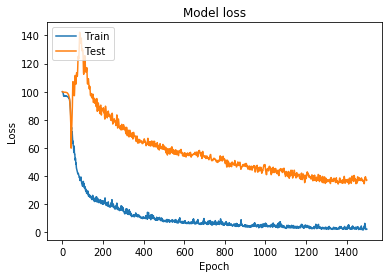

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Realizamos predicciones del test

In [14]:
model.predict(X_test)

array([[ 168.94511],
       [ 536.4932 ],
       [6237.117  ]], dtype=float32)

Comprobamos

In [15]:
y_test

,50
32,217
14,306
15,7272


# Predicción

In [16]:
country_prediction_namelist = ['Mexico']

In [17]:
db = open('database_prediction.csv','w')

print("Pais","Area","poblacion","Namerica","Samerica","Europe","Asia","Oceania","Africa","lat","long","Dia_inicio","PIB","Gasto_Salud",end=',',file=db,sep=',')
for value in range(dias_a_usar):
    print(value+1,file=db,end = ',')
print(dia_a_predecir,file=db)

for country in country_prediction_namelist:
    f = open('propiedades_por_pais.csv')
    for line in f:
        if(country == line.replace('\n','').split(',')[0]):
            pais=line.replace('\n','').split(',')[0]
            superficie=line.replace('\n','').split(',')[1]
            poblacion=line.replace('\n','').split(',')[2]
            namerica=line.replace('\n','').split(',')[3]
            samerica=line.replace('\n','').split(',')[4]
            europe=line.replace('\n','').split(',')[5]
            asia=line.replace('\n','').split(',')[6]
            oceania=line.replace('\n','').split(',')[7]
            africa=line.replace('\n','').split(',')[8]
            pib=line.replace('\n','').split(',')[9]
            salud_pib=line.replace('\n','').split(',')[10]            
    f.close()
    
    f = open('database_confirmed.csv')
    infected = []
    dia_inicio = 0
    for line in f:
        if(country == line.split(',')[1]):
            lat = float(line.split(',')[2])
            long = float(line.split(',')[3])
            country_data = []
            data = line.replace('\n','').split(',')[4:]
            for number in data:
                if(number != '0'):
                    infected.append(int(number))
                else:
                    dia_inicio += 1                    
    f.close()

    if(len(infected)<dias_a_usar):
        continue    
    print(pais,superficie,poblacion,namerica,samerica,europe,asia,oceania,africa,lat,long,dia_inicio,pib,salud_pib,end=',',file=db,sep=',')
    for value in infected[:dias_a_usar]:
        print(value,file=db,end = ',')
    if(len(infected)>=dia_a_predecir):
        print(infected[dia_a_predecir-1],file=db)
    else:
        print(-1,file=db)
db.close()          

In [18]:
data_prediction = pd.read_csv("database_prediction.csv",sep=',') 

In [19]:
data_prediction

,Pais,Area,poblacion,Namerica,Samerica,Europe,Asia,Oceania,Africa,lat,...,41,42,43,44,45,46,47,48,49,50
0,Mexico,1964375.0,126577691.0,1,0,0,0,0,0,23.6345,...,2785,3181,3441,3844,4219,4661,5014,5399,5847,-1


In [20]:
area_prediction = data_prediction.Area #returns a numpy array
normalized_area_prediction=(area_prediction-areamin)/(areamax-areamin)
data_prediction['Area'] = normalized_area_prediction

poblacion_prediction = data_prediction.poblacion #returns a numpy array
normalized_poblacion_prediction=(poblacion_prediction-poblacionmin)/(poblacionmax-poblacionmin)
data_prediction['poblacion'] = normalized_poblacion_prediction

lat_prediction = data_prediction.lat #returns a numpy array
normalized_lat_prediction=(lat_prediction-latmin)/(latmax-latmin)
data_prediction['lat'] = normalized_lat_prediction

long_prediction = data_prediction.long #returns a numpy array
normalized_long_prediction=(long_prediction-longmin)/(longmax-longmin)
data_prediction['long'] = normalized_long_prediction

Dia_inicio_prediction = data_prediction.Dia_inicio #returns a numpy array
normalized_Dia_inicio_prediction=(Dia_inicio_prediction-Dia_iniciomin)/(Dia_iniciomax-Dia_iniciomin)
data_prediction['Dia_inicio'] = normalized_Dia_inicio_prediction

PIB_prediction = data_prediction.PIB #returns a numpy array
normalized_PIB_prediction=(PIB_prediction-PIBmin)/(PIBmax-PIBmin)
data_prediction['PIB'] = normalized_PIB_prediction

Gasto_Salud_prediction = data_prediction.Gasto_Salud #returns a numpy array
normalized_Gasto_Salud_prediction=(Gasto_Salud_prediction-Gasto_Saludmin)/(Gasto_Saludmax-Gasto_Saludmin)
data_prediction['Gasto_Salud'] = normalized_Gasto_Salud_prediction

for i in range(dias_a_usar):
    infected = data_prediction[str(i+1)]
    normalize_infected = (infected-infectedmin)/(infectedmax-infectedmin)
    data_prediction[str(i+1)] = normalize_infected

In [21]:
data_prediction

,Pais,Area,poblacion,Namerica,Samerica,Europe,Asia,Oceania,Africa,lat,...,41,42,43,44,45,46,47,48,49,50
0,Mexico,0.11485,0.089279,1,0,0,0,0,0,0.579509,...,0.034419,0.039315,0.042529,0.047511,0.052147,0.057612,0.061976,0.066736,0.072275,-1


In [22]:
from sklearn.model_selection import train_test_split
X_prediction = pd.DataFrame()
X_prediction['Area'] = data_prediction['Area']
X_prediction['poblacion'] = data_prediction['poblacion']
#X_prediction['Namerica'] = data_prediction['Namerica']
#X_prediction['Samerica'] = data_prediction['Samerica']
#X_prediction['Europe'] = data_prediction['Europe']
#X_prediction['Asia'] = data_prediction['Asia']
#X_prediction['Oceania'] = data_prediction['Oceania']
#X_prediction['Africa'] = data_prediction['Africa']
X_prediction['lat'] = data_prediction['lat']
X_prediction['long'] = data_prediction['long']
X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
X_prediction['PIB'] = data_prediction['PIB']
X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
for i in range(1,dias_a_usar+1):
    X_prediction[str(i)] = data_prediction[str(i)]
Y_prediction = pd.DataFrame()
Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
print(X_prediction.shape, Y_prediction.shape)

(1, 56) (1, 1)


In [23]:
model.predict(X_prediction)

array([[6745.729]], dtype=float32)

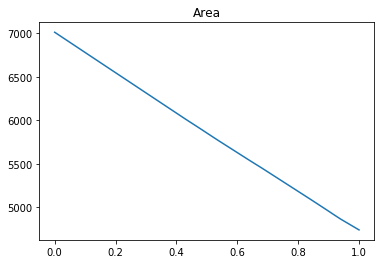

In [24]:
pred_area = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = np.asarray([i])#data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_area.append(model.predict(X_prediction)[0])
plt.title("Area")
plt.plot(x,pred_area)

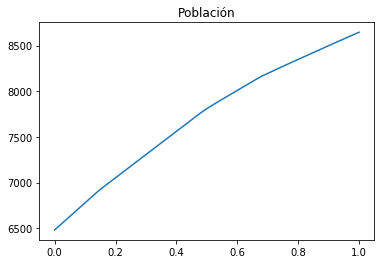

In [25]:
pred_poblacion = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = np.asarray([i])#data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_poblacion.append(model.predict(X_prediction)[0])
plt.title("Población")
plt.plot(x,pred_poblacion)

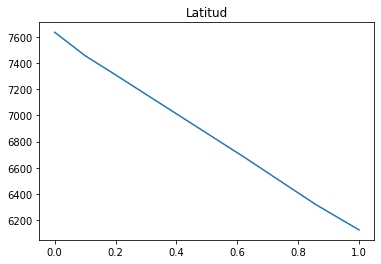

In [26]:
pred_latitud = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = np.asarray([i])#data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_latitud.append(model.predict(X_prediction)[0])
plt.title("Latitud")
plt.plot(x,pred_latitud)

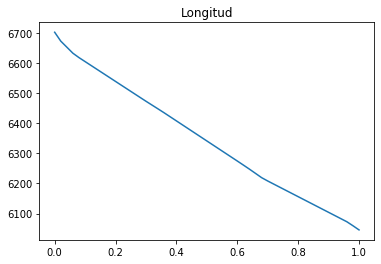

In [27]:
pred_longitud = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = np.asarray([i])#data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_longitud.append(model.predict(X_prediction)[0])
plt.title("Longitud")
plt.plot(x,pred_longitud)

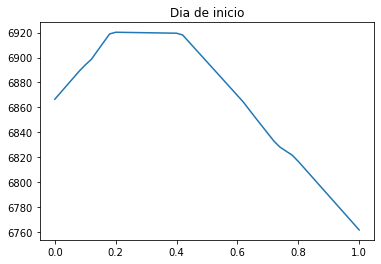

In [28]:
pred_dia_inicio = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = np.asarray([i])#data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_dia_inicio.append(model.predict(X_prediction)[0])
plt.title("Dia de inicio")
plt.plot(x,pred_dia_inicio)

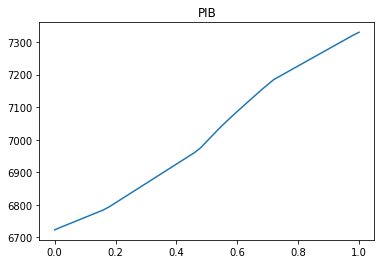

In [29]:
pred_pib = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = np.asarray([i])#data_prediction['PIB']
    X_prediction['Gasto_Salud'] = data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_pib.append(model.predict(X_prediction)[0])
plt.title("PIB")
plt.plot(x,pred_pib)

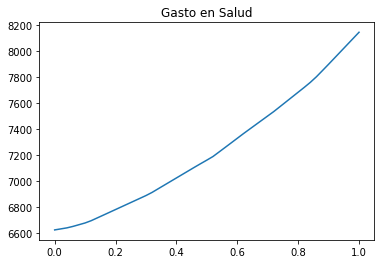

In [30]:
pred_gasto_salud = []
x = np.linspace(0,1.0,51)
for i in x:
    X_prediction = pd.DataFrame()
    X_prediction['Area'] = data_prediction['Area']
    X_prediction['poblacion'] = data_prediction['poblacion']  
    #X_prediction['Namerica'] = data_prediction['Namerica']
    #X_prediction['Samerica'] = data_prediction['Samerica']
    #X_prediction['Europe'] = data_prediction['Europe']
    #X_prediction['Asia'] = data_prediction['Asia']
    #X_prediction['Oceania'] = data_prediction['Oceania']
    #X_prediction['Africa'] = data_prediction['Africa']
    X_prediction['lat'] = data_prediction['lat']    
    X_prediction['long'] = data_prediction['long']
    X_prediction['Dia_inicio'] = data_prediction['Dia_inicio']
    X_prediction['PIB'] = data_prediction['PIB']
    X_prediction['Gasto_Salud'] = np.asarray([i])#data_prediction['Gasto_Salud']
    for i in range(1,dias_a_usar+1):
        X_prediction[str(i)] = data_prediction[str(i)]
    Y_prediction = pd.DataFrame()
    Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
    pred_gasto_salud.append(model.predict(X_prediction)[0])
plt.title("Gasto en Salud")
plt.plot(x,pred_gasto_salud)

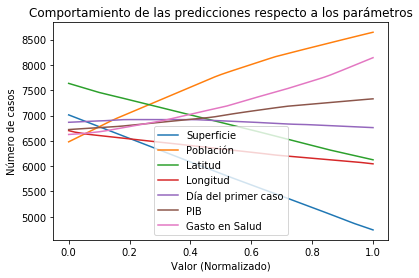

In [33]:
plt.plot(x,pred_area,label="Superficie")
plt.plot(x,pred_poblacion,label="Población")
plt.plot(x,pred_latitud,label="Latitud")
plt.plot(x,pred_longitud,label="Longitud")
plt.plot(x,pred_dia_inicio,label="Día del primer caso")
plt.plot(x,pred_pib,label="PIB")
plt.plot(x,pred_gasto_salud,label="Gasto en Salud")

plt.xlabel("Valor (Normalizado)")
plt.ylabel("Número de casos")
plt.title("Comportamiento de las predicciones respecto a los parámetros")

plt.legend()
plt.show()
#plt.savefig("comp.png", dpi=600)